## 特征组合  
### 设置  
定义输入并载入数据

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

In [3]:
def preprocess_features(california_housing_dataframe):  
    #选择需要的特征 
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    #创建合成特征
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [5]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
print("Training examples summary:")
display.display(training_examples.describe())
print("Valitation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Valitation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2639.2,539.3,1422.2,500.5,3.9,2.0
std,2.1,2.0,12.6,2183.0,425.3,1126.7,387.0,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.0,297.0,786.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2124.0,433.0,1165.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3137.0,646.0,1707.2,602.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Valitation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2654.4,539.6,1447.2,502.9,3.9,2.0
std,2.1,2.0,12.5,2172.8,412.3,1197.1,378.6,1.9,1.0
min,32.5,-124.3,2.0,2.0,2.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1468.0,296.0,796.8,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2137.5,435.5,1172.0,411.0,3.5,1.9
75%,37.7,-118.0,37.0,3180.0,654.0,1755.2,612.0,4.7,2.3
max,41.8,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,208.1
std,116.4
min,15.0
25%,119.8
50%,181.5
75%,265.9
max,500.0


Valitation targets summary:


,median_house_value
count,5000.0
mean,205.4
std,114.9
min,15.0
25%,119.2
50%,177.2
75%,262.5
max,500.0


In [6]:
def construct_feature_columns(input_features):
  """
  构建特征列
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """构建输入函数
    """
    
    # Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### FTRL优化算法 
高维度线性模型可受益于使用一种基于梯度的优化方法，叫做 FTRL。该算法的优势是针对不同系数以不同方式调整学习速率，如果某些特征很少采用非零值，该算法可能比较实用（也非常适合支持 L1 正则化）。

In [10]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods

  # Create a linear regressor object.
    #使用一个新的优化器FTRL
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
  # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets["median_house_value"], 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
    )
    # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 140.88
  period 01 : 119.91
  period 02 : 113.03
  period 03 : 109.91
  period 04 : 111.38
  period 05 : 110.08
  period 06 : 106.17
  period 07 : 107.40
  period 08 : 110.21
  period 09 : 109.24
Model training finished.


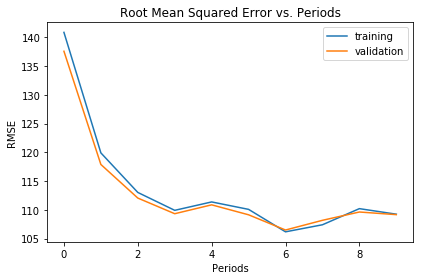

In [13]:
_ = train_model(
    learning_rate=0.1,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

离散特征的独热编码
通常，在训练逻辑回归模型之前，离散（即字符串、枚举、整数）特征会转换为二元特征系列。

例如，假设我们创建了一个合成特征，可以采用 0、1 或 2 中的任何值，并且我们还具有以下几个训练点：
|   #   |   feature_value   |      
| ---- | ---- |   
|0    | 2   |  
|1    |0    |   
|2    |1    |  
对于每个可能的分类值，我们都会创建一个新的二元**实值**特征，该特征只能采用两个可能值中的一个：如果示例中包含该值，则值为 1.0；如果不包含，则值为 0.0。在上述示例中，分类特征会被转换成三个特征，现在训练点如下所示：  

|#	feature_value_0	feature_value_1	feature_value_2  
0	0.0	0.0	1.0  
1	1.0	0.0	0.0  
2	0.0	1.0	0.0

### 分桶（分箱）特征
分桶也称为分箱。

例如，我们可以将 population 分为以下 3 个分桶：

* bucket_0 (< 5000)：对应于人口分布较少的街区
* bucket_1 (5000 - 25000)：对应于人口分布适中的街区
* bucket_2 (> 25000)：对应于人口分布较多的街区
根据前面的分桶定义，以下 population 矢量：

[[10001], [42004], [2500], [18000]]
将变成以下经过分桶的特征矢量：

[[1], [2], [0], [1]]
这些特征值现在是分桶索引。请注意，这些索引被视为离散特征。通常情况下，这些特征将被进一步转换为上述独热表示法，但这是以透明方式实现的。

要为分桶特征定义特征列，我们可以使用 bucketized_column（而不是使用 numeric_column），该列将数字列作为输入，并使用 boundardies 参数中指定的分桶边界将其转换为分桶特征。以下代码为 households 和 longitude 定义了分桶特征列；get_quantile_based_boundaries 函数会根据分位数计算边界，以便每个分桶包含相同数量的元素。

In [23]:
#定义分桶特征列
#先计算分位数quantiles,然后计算桶的边界
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

#将households分为7个桶
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["households"], 7))

#将longitude分为10个桶
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
        california_housing_dataframe["longitude"], 10))

bucketized_households


array([0.14285714, 0.28571429, 0.42857143, 0.57142857, 0.71428571,
       0.85714286])

### 使用分桶特征列训练数据

In [30]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
      """ 
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
          training_examples["households"], 7))

  # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
          training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
          training_examples["latitude"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
          training_examples["housing_median_age"], 7))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
          training_examples["median_income"], 7))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
          training_examples["rooms_per_person"], 7))
  
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])
  
    return feature_columns


Training model...
RMSE (on training data):
  period 00 : 170.52
  period 01 : 144.15
  period 02 : 127.63
  period 03 : 116.30
  period 04 : 108.27
  period 05 : 102.33
  period 06 : 97.82
  period 07 : 94.26
  period 08 : 91.37
  period 09 : 88.95
Model training finished.


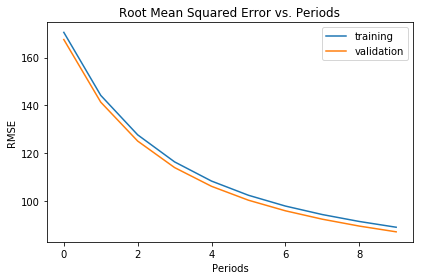

In [31]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 特征组合
组合两个（或更多个）特征是使用线性模型来学习非线性关系的一种聪明做法。在我们的问题中，如果我们只使用 latitude 特征进行学习，那么该模型可能会发现特定纬度（或特定纬度范围内，因为我们已经将其分桶）的城市街区更可能比其他街区住房成本高昂。longitude 特征的情况与此类似。但是，如果我们将 longitude 与 latitude 组合，产生的组合特征则代表一个明确的城市街区。如果模型发现某些城市街区（位于特定纬度和经度范围内）更可能比其他街区住房成本高昂，那么这将是比单独考虑两个特征更强烈的信号。

目前，特征列 API 仅支持组合离散特征。要组合两个连续的值（比如 latitude 或 longitude），我们可以对其进行分桶。

如果我们组合 latitude 和 longitude 特征（例如，假设 longitude 被分到 2 个分桶中，而 latitude 有 3 个分桶），我们实际上会得到 6 个组合的二元特征。当我们训练模型时，每个特征都会分别获得自己的权重。

### 使用特征组合训练模型
在模型中添加 longitude 与 latitude 的特征组合，训练模型，然后确定结果是否有所改善。

请参阅有关 crossed_column() 的 TensorFlow API 文档，了解如何为您的组合构建特征列。hash_bucket_size 可以设为 1000。

In [37]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
      """ 
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
          training_examples["households"], 7))

  # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
          training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
          training_examples["latitude"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
          training_examples["housing_median_age"], 7))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
          training_examples["median_income"], 7))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
          training_examples["rooms_per_person"], 7))
  
    long_x_lat_x_per = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude, bucketized_rooms_per_person]), hash_bucket_size=10000)
    #set创建一个无序不重复集，可进行关系测试
    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person,
        long_x_lat_x_per])
  
    return feature_columns

Training model...
RMSE (on training data):
  period 00 : 168.34
  period 01 : 140.73
  period 02 : 123.40
  period 03 : 111.49
  period 04 : 102.96
  period 05 : 96.60
  period 06 : 91.76
  period 07 : 88.02
  period 08 : 84.84
  period 09 : 82.38
Model training finished.


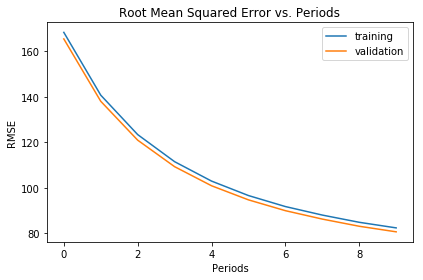

In [38]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)